In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, InputLayer, Dropout

import warnings
warnings.filterwarnings('ignore')

In [2]:
target_ticker = 'HRC=F'
tickers = ([target_ticker, 'SHV', 'GC=F', 'PL=F'  ])

In [3]:
raw_data = pd.read_excel('Data/Data_weekly_raw.xlsx')

raw_data['Date'] = pd.to_datetime(raw_data.Date)
raw_data.set_index('Date', inplace=True)

df = raw_data[tickers]
df = pd.DataFrame(df.pct_change().dropna())

In [4]:
def create_multifeature_data(df, window_size):
    y = df[window_size:]
    y = y[target_ticker]
    n = df.shape[0]
    X = np.stack([df[i: j] 
                  for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y

In [5]:
window_size = 16

In [6]:
X, y = create_multifeature_data(df=df, window_size=window_size)
X.shape, y.shape

((818, 16, 4), (818,))

In [7]:
train_size = int(round(len(X)*0.6, 0))
val_size = int(round(len(X)*0.2, 0))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:(val_size+train_size)], y[train_size:(val_size+train_size)]
X_test, y_test = X[(val_size+train_size):], y[(val_size+train_size):]

n_obs, window_size, n_features = X_train.shape

In [8]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((491, 16, 4), (491,), (164, 16, 4), (164,), (163, 16, 4), (163,))

In [9]:
model_architecture = Sequential()
model_architecture.add(InputLayer((window_size, n_features)))
model_architecture.add(Conv1D(50, kernel_size=5, activation='tanh', padding='same'))
model_architecture.add(Dropout(0.5))
model_architecture.add(LSTM(50, activation='tanh', dropout=0.5, recurrent_dropout=0.5))
model_architecture.add(Dense(10, activation='tanh'))
model_architecture.add(Dropout(0.5))
model_architecture.add(Dense(1, 'linear'))
model_architecture.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 16, 50)            1050      
                                                                 
 dropout (Dropout)           (None, 16, 50)            0         
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 21771 (85.04 KB)
Trainable params: 21771 

In [10]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08
)

In [11]:
model_architecture.compile(loss='mean_squared_error', 
            optimizer=optimizer)

In [12]:
path = Path("Models")

cnn_path = (path / 'model_CNN_LSTM_MCD_multivariate').as_posix()
checkpointer = ModelCheckpoint(filepath=cnn_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=100,
                              restore_best_weights=True)

In [14]:
model = model_architecture

In [15]:
model_training = model.fit(X_train,
                        y_train,
                        epochs=150,
                        batch_size=4,
                        shuffle=True,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, checkpointer],
                        verbose=0)



Epoch 1: val_loss improved from inf to 0.00166, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 2: val_loss improved from 0.00166 to 0.00142, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 3: val_loss improved from 0.00142 to 0.00131, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 4: val_loss improved from 0.00131 to 0.00131, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 5: val_loss improved from 0.00131 to 0.00127, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 6: val_loss did not improve from 0.00127

Epoch 7: val_loss did not improve from 0.00127

Epoch 8: val_loss did not improve from 0.00127

Epoch 9: val_loss did not improve from 0.00127

Epoch 10: val_loss did not improve from 0.00127

Epoch 11: val_loss did not improve from 0.00127

Epoch 12: val_loss did not improve from 0.00127

Epoch 13: val_loss did not improve from 0.00127

Epoch 14: val_loss did not improve from 0.00127

Epoch 15: val_loss did not improve from 0.00127

Epoch 16: val_loss did not improve from 0.00127

Epoch 17: val_loss did not improve from 0.00127

Epoch 18: val_loss did not improve from 0.00127

Epoch 19: val_loss improved from 0.00127 to 0.00127, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 20: val_loss did not improve from 0.00127

Epoch 21: val_loss did not improve from 0.00127

Epoch 22: val_loss did not improve from 0.00127

Epoch 23: val_loss did not improve from 0.00127

Epoch 24: val_loss improved from 0.00127 to 0.00126, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 25: val_loss did not improve from 0.00126

Epoch 26: val_loss did not improve from 0.00126

Epoch 27: val_loss did not improve from 0.00126

Epoch 28: val_loss improved from 0.00126 to 0.00126, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 29: val_loss did not improve from 0.00126

Epoch 30: val_loss did not improve from 0.00126

Epoch 31: val_loss did not improve from 0.00126

Epoch 32: val_loss did not improve from 0.00126

Epoch 33: val_loss did not improve from 0.00126

Epoch 34: val_loss improved from 0.00126 to 0.00126, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 35: val_loss improved from 0.00126 to 0.00126, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 36: val_loss did not improve from 0.00126

Epoch 37: val_loss did not improve from 0.00126

Epoch 38: val_loss improved from 0.00126 to 0.00125, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 39: val_loss did not improve from 0.00125

Epoch 40: val_loss did not improve from 0.00125

Epoch 41: val_loss improved from 0.00125 to 0.00122, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 42: val_loss improved from 0.00122 to 0.00121, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 43: val_loss did not improve from 0.00121

Epoch 44: val_loss did not improve from 0.00121

Epoch 45: val_loss did not improve from 0.00121

Epoch 46: val_loss did not improve from 0.00121

Epoch 47: val_loss improved from 0.00121 to 0.00120, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 48: val_loss did not improve from 0.00120

Epoch 49: val_loss did not improve from 0.00120

Epoch 50: val_loss did not improve from 0.00120

Epoch 51: val_loss did not improve from 0.00120

Epoch 52: val_loss did not improve from 0.00120

Epoch 53: val_loss did not improve from 0.00120

Epoch 54: val_loss did not improve from 0.00120

Epoch 55: val_loss did not improve from 0.00120

Epoch 56: val_loss improved from 0.00120 to 0.00119, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 57: val_loss did not improve from 0.00119

Epoch 58: val_loss did not improve from 0.00119

Epoch 59: val_loss did not improve from 0.00119

Epoch 60: val_loss did not improve from 0.00119

Epoch 61: val_loss did not improve from 0.00119

Epoch 62: val_loss did not improve from 0.00119

Epoch 63: val_loss did not improve from 0.00119

Epoch 64: val_loss did not improve from 0.00119

Epoch 65: val_loss did not improve from 0.00119

Epoch 66: val_loss did not improve from 0.00119

Epoch 67: val_loss did not improve from 0.00119

Epoch 68: val_loss did not improve from 0.00119

Epoch 69: val_loss did not improve from 0.00119

Epoch 70: val_loss did not improve from 0.00119

Epoch 71: val_loss did not improve from 0.00119

Epoch 72: val_loss did not improve from 0.00119

Epoch 73: val_loss did not improve from 0.00119

Epoch 74: val_loss did not improve from 0.00119

Epoch 75: val_loss improved from 0.00119 to 0.00117, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tens

INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 76: val_loss did not improve from 0.00117

Epoch 77: val_loss did not improve from 0.00117

Epoch 78: val_loss did not improve from 0.00117

Epoch 79: val_loss did not improve from 0.00117

Epoch 80: val_loss did not improve from 0.00117

Epoch 81: val_loss improved from 0.00117 to 0.00117, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 82: val_loss did not improve from 0.00117

Epoch 83: val_loss did not improve from 0.00117

Epoch 84: val_loss did not improve from 0.00117

Epoch 85: val_loss did not improve from 0.00117

Epoch 86: val_loss did not improve from 0.00117

Epoch 87: val_loss did not improve from 0.00117

Epoch 88: val_loss did not improve from 0.00117

Epoch 89: val_loss did not improve from 0.00117

Epoch 90: val_loss did not improve from 0.00117

Epoch 91: val_loss improved from 0.00117 to 0.00115, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 92: val_loss did not improve from 0.00115

Epoch 93: val_loss did not improve from 0.00115

Epoch 94: val_loss did not improve from 0.00115

Epoch 95: val_loss improved from 0.00115 to 0.00114, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 96: val_loss did not improve from 0.00114

Epoch 97: val_loss did not improve from 0.00114

Epoch 98: val_loss improved from 0.00114 to 0.00114, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 99: val_loss did not improve from 0.00114

Epoch 100: val_loss did not improve from 0.00114

Epoch 101: val_loss did not improve from 0.00114

Epoch 102: val_loss improved from 0.00114 to 0.00113, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 103: val_loss did not improve from 0.00113

Epoch 104: val_loss improved from 0.00113 to 0.00113, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 105: val_loss improved from 0.00113 to 0.00112, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 106: val_loss did not improve from 0.00112

Epoch 107: val_loss did not improve from 0.00112

Epoch 108: val_loss improved from 0.00112 to 0.00111, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 109: val_loss did not improve from 0.00111

Epoch 110: val_loss did not improve from 0.00111

Epoch 111: val_loss did not improve from 0.00111

Epoch 112: val_loss did not improve from 0.00111

Epoch 113: val_loss did not improve from 0.00111

Epoch 114: val_loss did not improve from 0.00111

Epoch 115: val_loss improved from 0.00111 to 0.00110, saving model to Models\model_CNN_LSTM_MCD_multivariate
INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets


INFO:tensorflow:Assets written to: Models\model_CNN_LSTM_MCD_multivariate\assets



Epoch 116: val_loss did not improve from 0.00110

Epoch 117: val_loss did not improve from 0.00110

Epoch 118: val_loss did not improve from 0.00110

Epoch 119: val_loss did not improve from 0.00110

Epoch 120: val_loss did not improve from 0.00110

Epoch 121: val_loss did not improve from 0.00110

Epoch 122: val_loss did not improve from 0.00110

Epoch 123: val_loss did not improve from 0.00110

Epoch 124: val_loss did not improve from 0.00110

Epoch 125: val_loss did not improve from 0.00110

Epoch 126: val_loss did not improve from 0.00110

Epoch 127: val_loss did not improve from 0.00110

Epoch 128: val_loss did not improve from 0.00110

Epoch 129: val_loss did not improve from 0.00110

Epoch 130: val_loss did not improve from 0.00110

Epoch 131: val_loss did not improve from 0.00110

Epoch 132: val_loss did not improve from 0.00110

Epoch 133: val_loss did not improve from 0.00110

Epoch 134: val_loss did not improve from 0.00110

Epoch 135: val_loss did not improve from 0.00110


In [16]:
model_recall = load_model('Models/model_CNN_LSTM_MCD_multivariate')

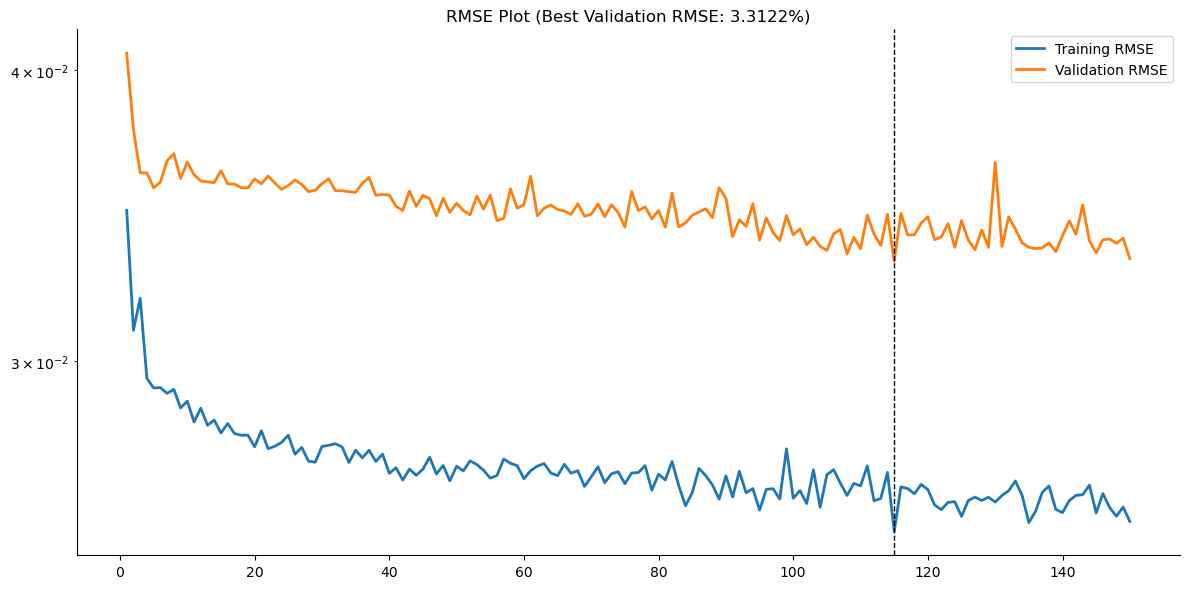

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

loss_history = pd.DataFrame(model_training.history).pow(0.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'RMSE Plot (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()

In [18]:
def mc_dropout_predict(model, X, n_iter):
    preds = []
    for i in range(n_iter):
        y_pred = model(X, training=True) #dropout active
        preds.append(y_pred.numpy())
    preds = np.array(preds)
    mean_preds = preds.mean(axis=0)
    std_preds = preds.std(axis=0)
    return mean_preds, std_preds, preds

In [19]:
def rmse_calc(y_data, mean_preds):
    rmse = mean_squared_error(y_data, mean_preds)**(0.5)
    return rmse

In [20]:
def results_dataset(model, X_data, y_data, n_iter):
    mean_preds, std_preds, preds = mc_dropout_predict(model, X_data, n_iter)
    
    test_results = pd.DataFrame(y_data).rename(columns={target_ticker: 'Actuals'})
    test_results['Test Predictions'] = mean_preds
    test_results['Prediction Std'] = std_preds
    test_results['Trend'] = (np.sign(test_results['Test Predictions']) ==
                             np.sign(test_results['Actuals'])).astype(int)
    
    test_results['Lower Bound'] = mean_preds - 3*std_preds
    test_results['Upper Bound'] = mean_preds + 3*std_preds

    ci_results=[]
    
    for i in range(len(test_results)):
        if test_results['Lower Bound'][i] <= test_results.Actuals[i] <= test_results['Upper Bound'][i]:
            ci_results.append(1)
        else: ci_results.append(0)

    test_results['CI Results'] = ci_results

    return test_results, preds

In [21]:
def success_rate(results_dataset):
    succ_rate = (round((results_dataset.iloc[:,3].sum()/
                (results_dataset.iloc[:,0] !=0).sum())*100,2))
    return succ_rate

In [22]:
def ci_interval_success(results_dataset):
    return round(((results_dataset['CI Results'].sum())/len(results_dataset))*100,2)

In [23]:
def plot_results(results_dataset, title):
    plt.figure(figsize=(12,6))
    plt.plot(results_dataset['Actuals'], label='Actuals', color='blue')
    plt.plot(results_dataset['Test Predictions'], label='Avg Forecast', color='red')
    plt.fill_between(results_dataset.index,
                     results_dataset['Lower Bound'],
                     results_dataset['Upper Bound'],
                     color='green', alpha=0.5, label='Model CI')
    plt.axhline(0, color='black', linestyle='--')

    plt.title(f'{title}')
    plt.legend()
    plt.show()

    rmse = round(rmse_calc(results_dataset['Actuals'], results_dataset['Test Predictions']),4)
    mae = round(mean_absolute_error(results_dataset['Actuals'], results_dataset['Test Predictions']), 4)
    succ_rate = success_rate(results_dataset)
    ci_succ_rate = ci_interval_success(results_dataset)


    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'Accuracy: {succ_rate}')
    print(f'CICR: {ci_succ_rate}')  

In [24]:
train_results, train_preds = results_dataset(model_recall, X_train, y_train, n_iter=100)
val_results, val_preds = results_dataset(model_recall, X_val, y_val, n_iter=100)
test_results, test_preds = results_dataset(model_recall, X_test, y_test, n_iter=100)

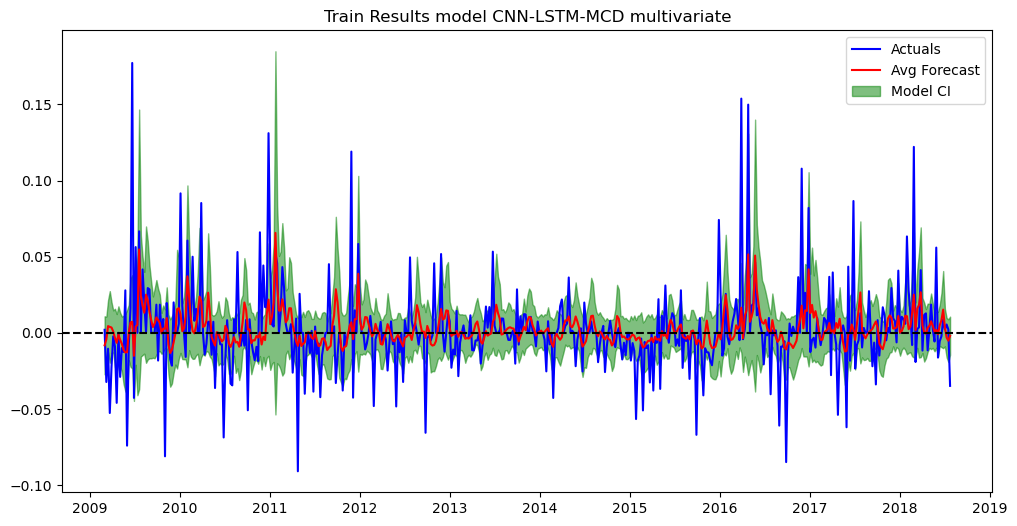

RMSE: 0.0252
MAE: 0.0157
Accuracy: 65.79
CICR: 77.39


In [25]:
plot_results(train_results, 'Train Results model CNN-LSTM-MCD multivariate')

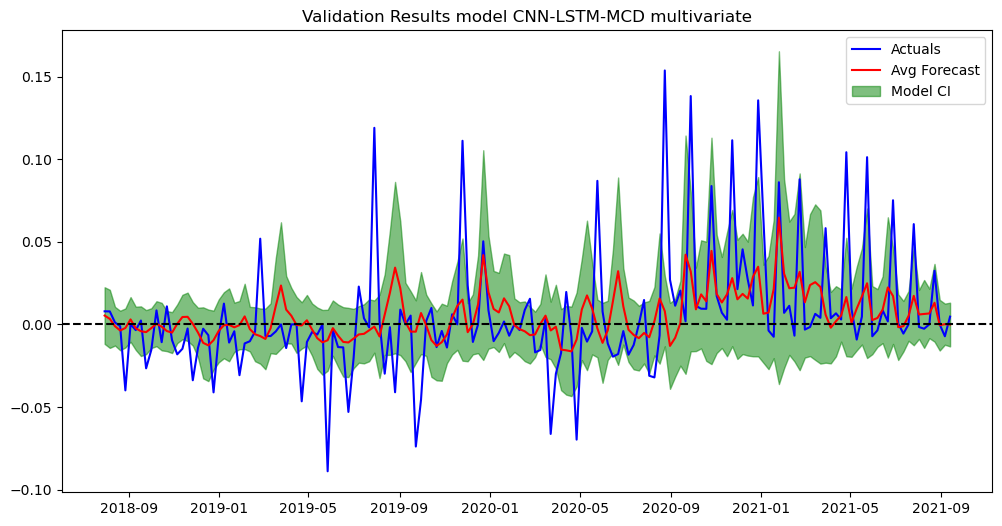

RMSE: 0.0335
MAE: 0.0218
Accuracy: 60.26
CICR: 73.17


In [26]:
plot_results(val_results, 'Validation Results model CNN-LSTM-MCD multivariate')

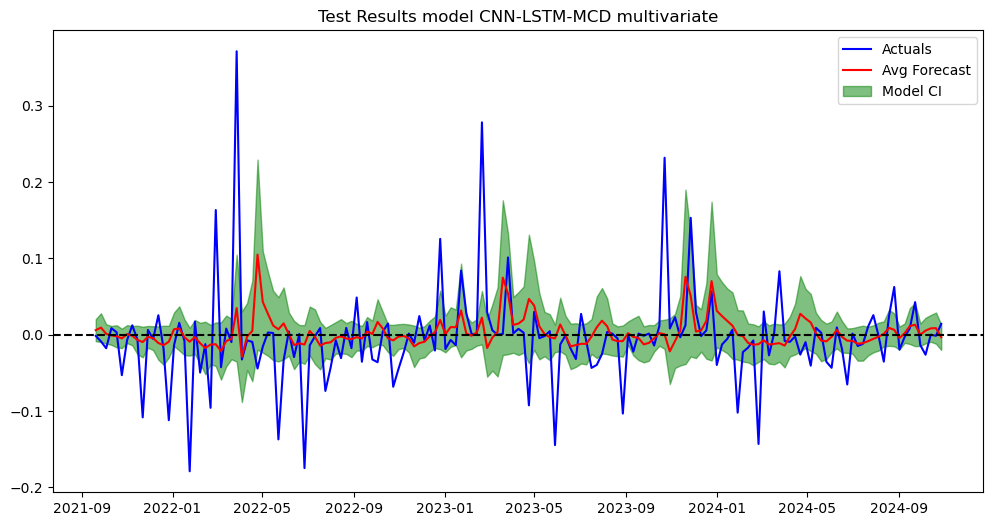

RMSE: 0.0605
MAE: 0.035
Accuracy: 55.97
CICR: 63.19


In [27]:
plot_results(test_results, 'Test Results model CNN-LSTM-MCD multivariate')

In [28]:
train_results_1 = train_results
train_results_1['Prices'] = raw_data[target_ticker]

val_results_1 = val_results
val_results['Prices'] = raw_data[target_ticker]

test_results_1 = test_results
test_results_1['Prices'] = raw_data[target_ticker]

In [29]:
def test_1(df):
    buy_prices = []
    avg_prices = []

    #alligning
    if len(df) % 2 != 0:
        df = df.iloc[1:]

    for i in range(0, len(df)-1, 2):
        prediction_week1 = df.iloc[i+1]['Test Predictions']
        if prediction_week1 > 0:
            buy_prices.append(df.iloc[i]['Prices'])
        else:
            buy_prices.append(df.iloc[i+1]['Prices'])

    for i in range(0, len(df), 2):
        group = df.iloc[i:i+2]
        avg_prices_group = group['Prices'].mean()
        avg_prices.append(avg_prices_group)
     
    return buy_prices, avg_prices

In [30]:
def compute_ci(values):
    mean_val = np.mean(values)
    std_val = np.std(values, ddof=1)
    ci_low, ci_high = stats.t.interval(
        confidence=0.95,
        df=len(values) - 1,
        loc=mean_val,
        scale=std_val / np.sqrt(len(values))
    )
    return round(mean_val, 2), round(ci_low, 2), round(ci_high, 2)

In [31]:
def test_1_MCD(df, preds):
    total_savings = []
    avg_savings_per_purchase = []
    model_expenses = []
    avg_expenses = []
    pct_savings = []

    for i in range(preds.shape[0]):
        results_temp = df.copy()
        results_temp['Test Predictions'] = preds[i]

        buy_prices, avg_prices = test_1(results_temp)

        total_sav = round(sum(avg_prices) - sum(buy_prices), 2)
        avg_sav = round((sum(avg_prices) - sum(buy_prices)) / len(avg_prices), 2)
        total_savings.append(total_sav)
        avg_savings_per_purchase.append(avg_sav)

        sum_buy_prices = round(sum(buy_prices),2)
        sum_avg_prices = round(sum(avg_prices),2)
        model_expenses.append(sum_buy_prices)
        avg_expenses.append(sum_avg_prices)

        saving_percentage = round(((sum_avg_prices-sum_buy_prices)/sum_avg_prices)*100, 2)
        pct_savings.append(saving_percentage)
    
    mean_model, low_model, high_model = compute_ci(model_expenses)
    mean_avg, low_avg, high_avg = compute_ci(avg_expenses)
    mean_total, low_total, high_total = compute_ci(total_savings)
    mean_pct, low_pct, high_pct = compute_ci(pct_savings)
    mean_per_purchase, low_per_purchase, high_per_purchase = compute_ci(avg_savings_per_purchase)

    print(f'Total Model Expenses: {mean_model}$   [95% CI: ({low_model}$, {high_model}$)]')
    print(f'Total Avg (Baseline) Expenses: {mean_avg}$')
    print(f'Total Savings: {mean_total}$   [95% CI: ({low_total}$, {high_total}$)]')
    print(f'Total Saving %: {mean_pct}%   [95% CI: ({low_pct}%, {high_pct}%)]')
    print(f'Avg Saving per Purchase: {mean_per_purchase}$   [95% CI: ({low_per_purchase}$, {high_per_purchase}$)]')


In [32]:
test_1_MCD(train_results_1, train_preds)

Total Model Expenses: 149646.38$   [95% CI: (149630.61$, 149662.14$)]
Total Avg (Baseline) Expenses: 150156.5$
Total Savings: 510.12$   [95% CI: (494.36$, 525.89$)]
Total Saving %: 0.34%   [95% CI: (0.33%, 0.35%)]
Avg Saving per Purchase: 2.08$   [95% CI: (2.02$, 2.15$)]


In [33]:
test_1_MCD(val_results_1, val_preds)

Total Model Expenses: 68097.36$   [95% CI: (68086.81$, 68107.91$)]
Total Avg (Baseline) Expenses: 68483.5$
Total Savings: 386.14$   [95% CI: (375.59$, 396.69$)]
Total Saving %: 0.56%   [95% CI: (0.55%, 0.58%)]
Avg Saving per Purchase: 4.71$   [95% CI: (4.58$, 4.84$)]


In [34]:
test_1_MCD(test_results_1, test_preds)

Total Model Expenses: 78745.84$   [95% CI: (78719.81$, 78771.87$)]
Total Avg (Baseline) Expenses: 79514.5$
Total Savings: 768.66$   [95% CI: (742.63$, 794.69$)]
Total Saving %: 0.97%   [95% CI: (0.93%, 1.0%)]
Avg Saving per Purchase: 9.49$   [95% CI: (9.17$, 9.81$)]


In [35]:
def test_2(df):
    lost_value = 0
    gained_value = 0
    hedging_cost = 0
    total_value = df.iloc[0]['Prices']

    for i in range(0, (len(df)-1)):
        prediction = df.iloc[i+1]['Test Predictions']
        actual = df.iloc[i+1]['Actuals']
        price_0 = df.iloc[i]['Prices']
        price_1 = df.iloc[i+1]['Prices']
        delta = price_0 - price_1
        if prediction < 0:
            if actual < 0:
                gained_value = gained_value + delta
            else:
                lost_value = lost_value - delta
            hedging_cost = hedging_cost + total_value * 0.001
            total_value = total_value - total_value * 0.001
        else:
            total_value = total_value - delta

    return lost_value, gained_value, total_value, hedging_cost


In [36]:
def test_2_MCD(df, preds):
    initial_price = df.iloc[0]['Prices']
    final_price = df.iloc[-1]['Prices']
    total_lost_value = []
    total_gained_value = []
    total_value = []
    total_hedging_cost = []

    for i in range(preds.shape[0]):
        results_temp = df.copy()
        results_temp['Test Predictions'] = preds[i]

        lost_value, gained_value, value, hedging_cost = test_2(results_temp)

        total_lost_value.append(lost_value)
        total_gained_value.append(gained_value)
        total_value.append(value)
        total_hedging_cost.append(hedging_cost)

    mean_lost_val, low_lost_val, high_lost_val = compute_ci(total_lost_value)
    mean_gained_val, low_gained_val, high_gained_val = compute_ci(total_gained_value)
    mean_total_val, low_total_val, high_total_val = compute_ci(total_value)
    mean_total_cost, low_total_cost, high_total_cost = compute_ci(total_hedging_cost)

    no_hedging_diff = round(((mean_total_val - final_price)/final_price)*100,2)
    constant_hedging = round(((mean_total_val - initial_price)/initial_price)*100,2)
    delta_value = round((mean_gained_val - mean_lost_val - mean_total_cost),2)

    print(f'Total Lost Value: {mean_lost_val}$   [95% CI: ({low_lost_val}$, {high_lost_val}$)]')
    print(f'Total Gained Value: {mean_gained_val}$   [95% CI: ({low_gained_val}$, {high_gained_val}$)]')
    print(f'Initial Price: {initial_price}')
    print(f'Final Price: {final_price}')
    print(f'Total Final Value: {mean_total_val}$   [95% CI: ({low_total_val}$, {high_total_val}$)]')
    print(f'Total Final Hedging Costs: {mean_total_cost}$   [95% CI: ({low_total_cost}$, {high_total_cost}$)]')
    print(f'Difference No-Hedging Strategy: {no_hedging_diff}%')
    print(f'Difference Constant Hedging Strategy: {constant_hedging}%')
    print(f'Mean Gained Value with Hedging Costs: {delta_value}$')

In [37]:
test_2_MCD(train_results_1, train_preds)

Total Lost Value: 568.48$   [95% CI: (555.65$, 581.3$)]
Total Gained Value: 1359.64$   [95% CI: (1344.84$, 1374.44$)]
Initial Price: 496.0
Final Price: 887.0
Total Final Value: 1472.45$   [95% CI: (1453.84$, 1491.06$)]
Total Final Hedging Costs: 205.71$   [95% CI: (202.71$, 208.72$)]
Difference No-Hedging Strategy: 66.0%
Difference Constant Hedging Strategy: 196.86%
Mean Gained Value with Hedging Costs: 585.45$


In [38]:
test_2_MCD(val_results_1, val_preds)

Total Lost Value: 269.1$   [95% CI: (255.42$, 282.78$)]
Total Gained Value: 523.63$   [95% CI: (513.75$, 533.51$)]
Initial Price: 894.0
Final Price: 1936.0
Total Final Value: 2129.78$   [95% CI: (2114.02$, 2145.53$)]
Total Final Hedging Costs: 60.75$   [95% CI: (59.7$, 61.81$)]
Difference No-Hedging Strategy: 10.01%
Difference Constant Hedging Strategy: 138.23%
Mean Gained Value with Hedging Costs: 193.78$


In [39]:
test_2_MCD(test_results_1, test_preds)

Total Lost Value: 647.63$   [95% CI: (624.34$, 670.92$)]
Total Gained Value: 2335.62$   [95% CI: (2300.64$, 2370.6$)]
Initial Price: 1933.0
Final Price: 714.0
Total Final Value: 2222.78$   [95% CI: (2181.28$, 2264.29$)]
Total Final Hedging Costs: 179.21$   [95% CI: (176.07$, 182.34$)]
Difference No-Hedging Strategy: 211.31%
Difference Constant Hedging Strategy: 14.99%
Mean Gained Value with Hedging Costs: 1508.78$
